In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

d:\anaconda\envs\env_v3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../../data/preprocessed/combined_data_preprocessed_Kbest_v1.csv')

In [3]:
# Prepare data
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [4]:
# Advanced target transformation
target_transformer = PowerTransformer(method='yeo-johnson')
y_train_trans = target_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_trans = target_transformer.transform(y_test.values.reshape(-1, 1)).flatten()

In [5]:
def inverse_transform(y_trans):
    return target_transformer.inverse_transform(y_trans.reshape(-1, 1)).flatten()


In [6]:
# Create SVM pipeline with scaling
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVR()
)

In [7]:
# Define parameter grid for SVM tuning
param_grid = {
    'svr__kernel': ['rbf', 'poly', 'sigmoid'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1],
    'svr__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
}

In [8]:
# Hyperparameter optimization with Optuna
def objective(trial):
    params = {
        'svr__kernel': trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid']),
        'svr__C': trial.suggest_float('C', 0.1, 100, log=True),
        'svr__epsilon': trial.suggest_float('epsilon', 0.01, 1.0),
        'svr__gamma': trial.suggest_categorical('gamma', ['scale', 'auto']) or trial.suggest_float('gamma', 1e-3, 10, log=True)
    }
    
    model = make_pipeline(
        StandardScaler(),
        SVR(**{k.split('__')[1]: v for k, v in params.items()})
    )
    
    score = cross_val_score(
        model, 
        X_train, 
        y_train_trans, 
        cv=3,  # Reduced for computational efficiency
        scoring='r2', 
        n_jobs=-1
    ).mean()
    
    return score

print("\nStarting SVM optimization with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-06-24 05:47:22,162] A new study created in memory with name: no-name-c186df07-6078-44fc-9b48-fc6bdedf3c3b



Starting SVM optimization with Optuna...


[I 2025-06-24 05:47:33,934] Trial 0 finished with value: 0.7641132027559009 and parameters: {'kernel': 'rbf', 'C': 10.50289638450438, 'epsilon': 0.3282736638602036, 'gamma': 'scale'}. Best is trial 0 with value: 0.7641132027559009.
[I 2025-06-24 05:47:39,613] Trial 1 finished with value: 0.667791091459995 and parameters: {'kernel': 'poly', 'C': 30.50964142692299, 'epsilon': 0.5603328562053318, 'gamma': 'scale'}. Best is trial 0 with value: 0.7641132027559009.
[I 2025-06-24 05:47:46,742] Trial 2 finished with value: -7.601956413599885 and parameters: {'kernel': 'sigmoid', 'C': 5.492855841692443, 'epsilon': 0.953958107000214, 'gamma': 'scale'}. Best is trial 0 with value: 0.7641132027559009.
[I 2025-06-24 05:47:52,310] Trial 3 finished with value: 0.6578724490596649 and parameters: {'kernel': 'poly', 'C': 13.223854608178627, 'epsilon': 0.5703165446076541, 'gamma': 'scale'}. Best is trial 0 with value: 0.7641132027559009.
[I 2025-06-24 05:47:56,805] Trial 4 finished with value: 0.69154407

In [9]:
# Create optimized model
best_params = study.best_params
optimized_svm = make_pipeline(
    StandardScaler(),
    SVR(
        kernel=best_params['kernel'],
        C=best_params['C'],
        epsilon=best_params['epsilon'],
        gamma=best_params['gamma']
    )
)

optimized_svm.fit(X_train, y_train_trans)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=42.54903386234164, epsilon=0.01858955937280225))])

In [10]:
# Final evaluation function
def evaluate_model(model, X, y_true_trans):
    y_pred_trans = model.predict(X)
    y_pred = inverse_transform(y_pred_trans)
    y_true = inverse_transform(y_true_trans)
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100  # Avoid division by zero
    
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Avg Price: {y_true.mean():.2f}")
    
    return y_pred

In [11]:

# Evaluate on test set
print("\nOptimized SVM Performance:")
y_pred_svm = evaluate_model(optimized_svm, X_test, y_test_trans)


Optimized SVM Performance:
R²: 0.7703
MAE: 252.85
MAPE: 15.74%
Avg Price: 1870.78


In [12]:
# Model interpretation using permutation importance
print("\nCalculating permutation importance...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Calculating permutation importance...


In [13]:
# Create fitted SVR model without pipeline for interpretation
fitted_svr = SVR(
    kernel=best_params['kernel'],
    C=best_params['C'],
    epsilon=best_params['epsilon'],
    gamma=best_params['gamma']
).fit(X_train_scaled, y_train_trans)

result = permutation_importance(
    fitted_svr, 
    X_test_scaled, 
    y_test_trans, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

C:\Users\User\AppData\Local\Temp\ipykernel_14620\1383049547.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


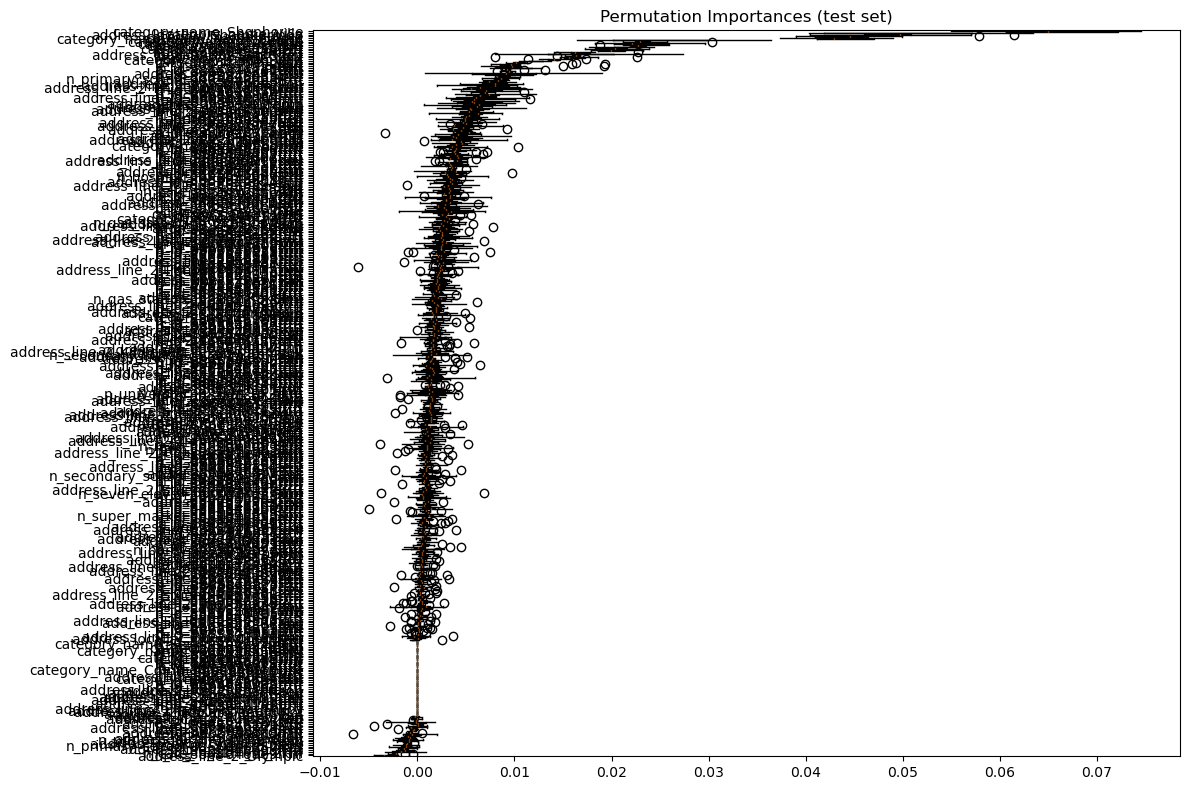

In [14]:
# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X.columns[sorted_idx]
)
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.savefig("svm_feature_importance.png")
plt.show()

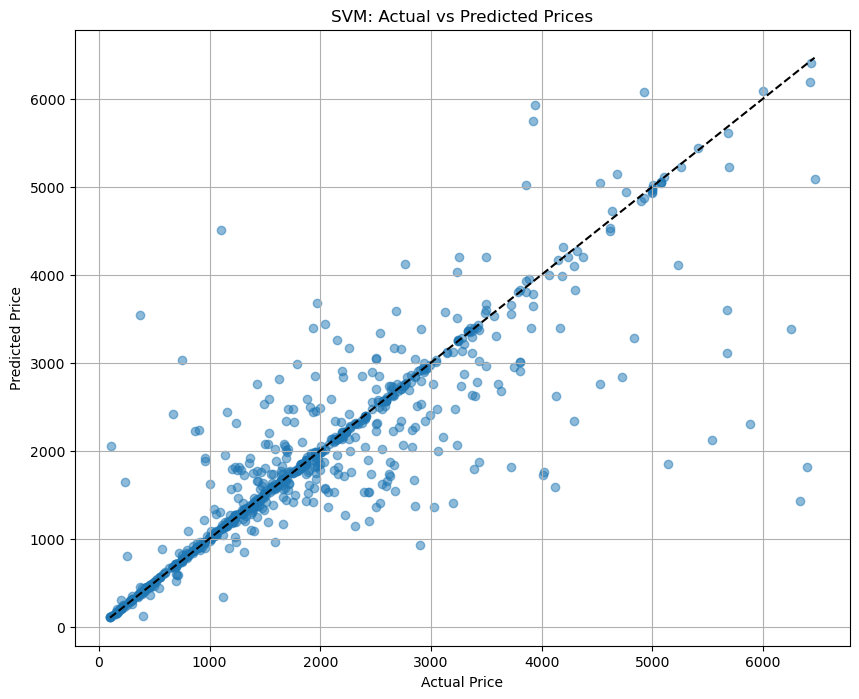

In [15]:
# Actual vs Predicted plot
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('SVM: Actual vs Predicted Prices')
    plt.grid(True)
    plt.savefig("svm_actual_vs_predicted.png")
    plt.show()

y_test_actual = inverse_transform(y_test_trans)
plot_actual_vs_predicted(y_test_actual, y_pred_svm)
